## Reading + Loading Benchmark

### Reading w/ skimage

In [1]:
# TODO : Clean tests

from skimage.io import imread
import glob
import time

image_paths = glob.glob('/nobackup/kp276129/test/1*/slice_010*') # 10 4k tif

t1 = time.perf_counter()
imgs = [imread(img) for img in image_paths]
t2 = time.perf_counter()

print(f"Time taken to read {len(image_paths)} images: {t2 - t1} seconds")

Time taken to read 10 images: 0.08580938912928104 seconds


### Reading w/ nvimagecodec

In [2]:
from nvidia import nvimgcodec
import time
import glob

params = nvimgcodec.DecodeParams(color_spec=nvimgcodec.ColorSpec.UNCHANGED, allow_any_depth=True)
dec = nvimgcodec.Decoder()

t1 = time.perf_counter()
imgs=dec.read(glob.glob('/nobackup/kp276129/test/1*/slice_010*'), params)
t2 = time.perf_counter()
print(f"Time taken to read images: {t2 - t1} seconds")
# print(img.__cuda_array_interface__)
# plt.imshow(img.cpu())

Time taken to read images: 0.14376681856811047 seconds


### Loading into GPU (CuPy)

In [3]:
import cupy as cp

imgs_cp = []

# Converting 10 images to CuPy arrays
t3 = time.perf_counter()
for img in imgs:
    imgs_cp.append(cp.asarray(img).squeeze())
t4 = time.perf_counter()

print(f"Time taken to convert {len(imgs)} images to CuPy arrays: {t4 - t3} seconds")

Time taken to convert 10 images to CuPy arrays: 0.06923903711140156 seconds


### Processing vnsr2d

In [4]:
import sys
sys.path.append('..')
from src.pyvsnr import vsnr2d

filters=[{'name':'Dirac', 'noise_level':0.35}]

# Time to apply vsnr2d to 10 images one by one
t5 = time.perf_counter()
for img in imgs_cp:
    vsnr2d(img, filters)
t6 = time.perf_counter()

print(f"Time taken to apply vsnr2d to {len(imgs)} images: {t6 - t5} seconds")

Time taken to apply vsnr2d to 10 images: 7.276724968105555 seconds


### Pyvsnr Average Time

In [5]:
import sys
sys.path.append('..')
from src.pyvsnr import vsnr2d
import cupy as cp
import time

filters=[{'name':'Dirac', 'noise_level':0.35}]
img = cp.random.rand(2048, 2048).astype(cp.float32)
nit=200

# Calculatin average time for 100 images
t1 = time.perf_counter()
for i in range(nit):
    vsnr2d(img, filters)
t2 = time.perf_counter()

# print average
print(f"Average time to apply vsnr2d: {(t2-t1)/nit} seconds")

Average time to apply vsnr2d: 0.14772265328094364 seconds


### Pyvsnr Batch Average Time

In [7]:
import sys
sys.path.append('..')
from pyvsnr.vsnr2d import vsnr2d
import cupy as cp
import time


def batch_generator(images, batch_size):
    for i in range(0, len(images), batch_size):
        yield images[i:i+batch_size]


nb_img = 200
batch_size = 10
filters=[{'name':'Dirac', 'noise_level':0.35}]
imgs = cp.random.rand(nb_img, 2048, 2048).astype(cp.float32)

t1 = time.perf_counter()
for batch in batch_generator(imgs, batch_size):
    vsnr2d(batch, filters)
t2 = time.perf_counter()

print(f"Average time to apply vsnr2d_batch: {(t2-t1)/nb_img} seconds")


Average time to apply vsnr2d_batch: 0.12653447344899177 seconds


### Time Distribution

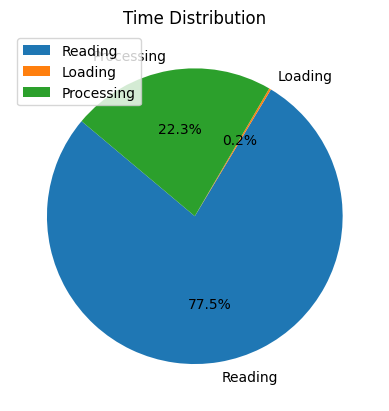

In [8]:
import matplotlib.pyplot as plt

activities = ['Reading', 'Loading', 'Processing']

time_taken = [t2-t1, t4-t3, t6-t5]

# Create a pie chart
plt.pie(time_taken, labels=activities, autopct='%1.1f%%', startangle=140)

# Add title and legend
plt.title('Time Distribution')
plt.legend(activities, loc="best")

# Display the plot
plt.show()

## Profiling

### Pyvsnr VRAM Usage

In [9]:
import sys
import cupy as cp
sys.path.append('..')
from src.pyvsnr import vsnr2d

filters=[{'name':'Dirac', 'noise_level':0.35}]
nb_img = 1

for _ in range(nb_img):
    img = cp.random.rand(4224, 4224)
    vsnr2d(img, filters)

### Pyvsnr VRAM Profiling

In [10]:
%load_ext memory_profiler
import sys
sys.path.append('..')
from src.pyvsnr import vsnr2d
import cupy as cp

%mprun -f vsnr2d vsnr2d(cp.random.rand(4224, 4224), [{'name':'Dirac', 'noise_level':0.35}])

Filename: /home/kp276129/Documents/pyvsnr/tests/../src/pyvsnr/vsnr2d.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   343    489.2 MiB    489.2 MiB           1   def vsnr2d(
   344                                             imgs,
   345                                             filters,
   346                                             maxit=20,
   347                                             algo='auto',
   348                                             beta=10.0,
   349                                             norm=True,
   350                                             cvg_threshold=0,
   351                                             return_cvg=False,
   352                                         ):
   353                                             r"""
   354                                             Calculate the corrected image using the 2D-VSNR algorithm in libvsnr2d.dll
   355                                         
   356                 

### VRAM Usage for Batch Processing FFT

748.0
748.0
749.0
748.7333333333333


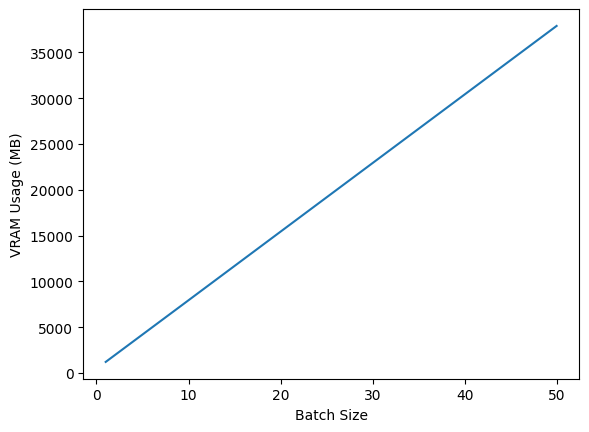

In [11]:
import cupy as cp
import matplotlib.pyplot as plt 

def image_generator(nb_img, batch_size):
    for i in range(0, nb_img, batch_size):
        batch_imgs = cp.random.rand(batch_size, 4224, 4224, dtype=cp.float32)
        yield batch_imgs

batch_size = 2
nb_img = 100

# Processing simple FFT
for batch in image_generator(nb_img, batch_size):
    imgs_corr = cp.fft.fft2(batch)

batch_sizes = [1,2,10,20,50]
vram_usage = [1215,1963,7947,15437,37899]

# Calculate VRAM usage per image
for i in range(1, len(batch_sizes)):
    vram_per_image = (vram_usage[i] - vram_usage[i-1]) / (batch_sizes[i] - batch_sizes[i-1])
    print(vram_per_image)

plt.xlabel('Batch Size')
plt.ylabel('VRAM Usage (MB)')
plt.plot(batch_sizes, vram_usage)

### Pyvsnr Profiling

In [12]:
import sys
import pstats
import cProfile
import io

sys.path.append('../')
import src.pyvsnr as pyvsnr
import cupy as cp

img = cp.random.rand(4200, 4200)
filters=[{'name':'Dirac', 'noise_level':0.35}]

pr = cProfile.Profile()
pr.enable()

pyvsnr.vsnr2d_single(img, filters)

pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('time')
ps.print_stats()

print(s.getvalue())

         6978 function calls in 0.858 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.645    0.645    0.700    0.700 /home/kp276129/Documents/pyvsnr/tests/../src/pyvsnr/vsnr2d_single.py:202(vsnr_admm)
        9    0.133    0.015    0.133    0.015 {method 'load' of 'cupy.cuda.function.Module' objects}
        1    0.039    0.039    0.039    0.039 {method 'get' of 'cupy._core.core._ndarray_base' objects}
       18    0.011    0.001    0.011    0.001 {built-in method posix.stat}
        1    0.006    0.006    0.006    0.006 {built-in method builtins.max}
       20    0.005    0.000    0.005    0.000 /home/kp276129/Documents/pyvsnr/tests/../src/pyvsnr/vsnr2d_single.py:80(update_y)
        9    0.002    0.000    0.002    0.000 {built-in method io.open}
       92    0.002    0.000    0.009    0.000 {method 'flatten' of 'cupy._core.core._ndarray_base' objects}
       91    0.002    0.000    0.002    0.000 {method 'f

## Others

### Batch vs Individual Processing

#### Batch

In [13]:
import time
import cupy as cp

def image_generator(nb_img, batch_size):
    for i in range(0, nb_img, batch_size):
        batch_imgs = cp.random.rand(batch_size, 4224, 4224, dtype=cp.float32)

        # cp.fft.config.get_plan_cache().clear()
        # cp.get_default_memory_pool().free_all_blocks()
        # cp.get_default_pinned_memory_pool().free_all_blocks()

        yield batch_imgs

batch_size = 20
nb_img = 200

# Need to measure one method at a time otherwise the first is faster


# Initialize an empty array for the results
# imgs_corr = cp.zeros((nb_img, 4224, 4224), dtype=cp.complex64)

t7 = time.perf_counter()
# Process the images in batches
for batch in image_generator(nb_img, batch_size):
    # imgs_corr[i*batch_size:(i+1)*batch_size] = cp.fft.fft2(batch)
    cp.fft.fft2(batch)
t8 = time.perf_counter()

print(f"Time taken to apply FFT to {nb_img} images in batches: {t8 - t7} seconds")

Time taken to apply FFT to 200 images in batches: 0.011978868395090103 seconds


#### Individual

In [14]:
import time
import cupy as cp

nb_img = 200
img = cp.random.rand(4224, 4224, dtype=cp.float32)

t9 = time.perf_counter()
# Process the images individually
for i in range(nb_img):
        # imgs_corr_2[i*batch_size+j] = cp.fft.fft2(img)
        cp.fft.fft2(img)
t10 = time.perf_counter()

print(f"Time taken to apply FFT to {nb_img} images individually: {t10 - t9} seconds")

Time taken to apply FFT to 200 images individually: 0.43631675466895103 seconds


### Testing different batch sizes for Pyvsnr

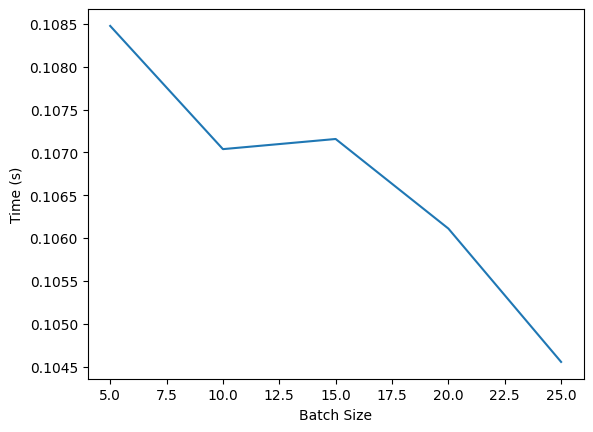

In [16]:
import sys
sys.path.append('..')

from pyvsnr.vsnr2d import vsnr2d
import matplotlib.pyplot as plt   
import cupy as cp
import time

def batch_generator(images, batch_size):
    for i in range(0, len(images), batch_size):
        yield cp.stack(images[i:i+batch_size])

filters=[{'name':'Dirac', 'noise_level':0.35}]
img = cp.random.rand(2048, 2048).astype(cp.float32)

batch_sizes = [5,10,15,20,25]
times = []

for batch_size in batch_sizes:
    t1 = time.perf_counter()
    for batch in batch_generator([img]*200, batch_size):
        vsnr2d(batch, filters)
    t2 = time.perf_counter()
    times.append((t2-t1)/200)

    cp.fft.config.get_plan_cache().clear()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()



plt.xlabel('Batch Size')
plt.ylabel('Time (s)')
plt.plot(batch_sizes, times)

### Multrithreading on pyvsnr

In [17]:
import sys
from multiprocessing import Pool
sys.path.append('..')
from src.pyvsnr import vsnr2d
import numpy as np
import time

filters=[{'name':'Dirac', 'noise_level':0.35}]
img = np.random.rand(2048, 2048) # CuPy usage leads to CUDA initialization error
nit=200

def task(i):
    vsnr2d(img, filters,algo="cuda")

# Calculating average time for 100 images
t1 = time.perf_counter()
with Pool(10) as pool:
    pool.map(task, range(nit))
t2 = time.perf_counter()

# print average
print(f"Average time to apply vsnr2d: {(t2-t1)/nit} seconds")


ValueError: algo must be 'cupy', or 'numpy'

### imread vs imread_collection : Same

In [ ]:
from skimage.io import imread, imread_collection
import glob
import time

image_paths = glob.glob('/nobackup/kp276129/test/1*/*')

# Method 1 : Read with imread_collection
t1 = time.perf_counter()
imgs1 = list(imread_collection(image_paths))
t2 = time.perf_counter()
print(f"Time taken to read images with imread_collection: {t2 - t1} seconds")

# Method 2 : Read with imread
t3 = time.perf_counter()
imgs2 = [imread(path) for path in image_paths]
t4 = time.perf_counter()
print(f"Time taken to read images with imread: {t4 - t3} seconds")


### Nvimagecodec doesn't match the original image

In [ ]:
from nvidia import nvimgcodec
import glob
import time
import cupy as cp
from matplotlib import pyplot as plt
from tifffile import imread

image_paths = glob.glob('/nobackup/kp276129/test/1*/*') # 10 4k tif
data_list = []

# Read 100 images
t1 = time.perf_counter()
params = nvimgcodec.DecodeParams(color_spec=nvimgcodec.ColorSpec.UNCHANGED, allow_any_depth=True)
dec = nvimgcodec.Decoder()
imgs = dec.read(image_paths, params)
t2 = time.perf_counter()
print(f"Time taken to read {len(image_paths)} images: {t2 - t1} seconds")

img=dec.read(image_paths[0], params)
# print(img1.__cuda_array_interface__)
img=cp.asarray(img).squeeze().get()
print(img.shape, img.max(), img.dtype)
plt.figure()
plt.imshow(img) 

img0 = imread(image_paths[0])
print(img0.shape, img0.max(), img0.dtype)
plt.figure()
plt.imshow(img0)
print(img0.max())
assert cp.allclose(img0, img), "The images do not match"


### Minimum Reproducible Example

In [ ]:
import cupy as cp
import numpy as np
from nvidia import nvimgcodec
import matplotlib.pyplot as plt
from tifffile import imread, imwrite

def sh_info(img, header=""):
    print(header)
    print(f"\tShape: {img.shape}")
    print(f"\tMin value: {img.min()}")
    print(f"\tMax value: {img.max()}")
    print(f"\tData type: {img.dtype}")

# Creating a random 16-bit image
arr = np.random.random((4096, 4096))
arr *= 60000
arr[100:400, 100:400] = 61000
arr = arr.astype(np.uint16)
sh_info(arr, "Original Image")

# Writing the image to a tif file and reading it back
imwrite('test.tif', arr, dtype=np.uint16)
img0 = imread('test.tif')
sh_info(img0, "tifffile Decoded Image")

# Decode the image using nvimgcodec
params = nvimgcodec.DecodeParams(color_spec=nvimgcodec.ColorSpec.UNCHANGED, allow_any_depth=True)
dec = nvimgcodec.Decoder()
img_decoded = dec.read('test.tif', params)

# Convert the decoded image to a CuPy array
cp_img = cp.asarray(img_decoded).get()
sh_info(cp_img, "nvImageCodec Decoded Image")

# Create a figure with 3 subplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(arr)

plt.subplot(1, 3, 2)
plt.title("tifffile Decoded Image")
plt.imshow(img0)

plt.subplot(1, 3, 3)
plt.title('nvImageCodec Decoded Image')
plt.imshow(cp_img)

plt.tight_layout()
plt.show()

### Minimum Reproducible Example #2

In [ ]:
from nvidia import nvimgcodec
import matplotlib.pyplot as plt
from skimage.io import imread
import cupy as cp

def sh_info(img):
    print(f"\tShape: {img.shape}")
    print(f"\tMin value: {img.min()}")
    print(f"\tMax value: {img.max()}")
    print(f"\tData type: {img.dtype}")
    
img_pth = './slice_00101_z=1.0988um.tif'

params = nvimgcodec.DecodeParams(color_spec=nvimgcodec.ColorSpec.UNCHANGED, allow_any_depth=True)
dec = nvimgcodec.Decoder()

# Loading with nvImageCodec
img=dec.read(img_pth, params)
img=cp.asarray(img).squeeze().get()

# Loading with skimage
img1 = imread(img_pth)

# Expected Output
print("skimage:")
sh_info(img1)
plt.title('Expected Image (skimage)')
plt.imshow(img1)

# Actual Output
print("nvImageCodec:")
sh_info(img)
plt.figure()
plt.title('Image (nvImageCodec)')
plt.imshow(img) 

assert cp.allclose(img1, img), "The images do not match"


### Use streams to overlap data transfer and computation

In [ ]:
import cupy as cp
from tifffile import imread
import glob
import time
from cupyx.scipy.ndimage import gaussian_filter, sobel
from concurrent.futures import ThreadPoolExecutor

# List of image paths
image_paths = glob.glob('/nobackup/kp276129/test/2*/*')
num_img = 100
batch_size = 10

def process_image(image):
    # Apply a Gaussian blur
    blurred = gaussian_filter(image, sigma=1)

    # Apply a Sobel filter
    filtered = sobel(blurred)

    return filtered

# Function to load a batch of images
def load_batch(paths):
    return [cp.array(imread(path)) for path in paths]

# Function to process a batch of images
def process_batch(batch):
    return [process_image(image) for image in batch]

# Create a ThreadPoolExecutor with more workers for better concurrency
executor = ThreadPoolExecutor(max_workers=1)

# Load the first batch of images
batch = load_batch(image_paths[:batch_size])
next_batch = None

t1 = time.perf_counter()
for i in range(0, num_img, batch_size):
    # Process the current batch in the default stream
    result = process_batch(batch)

    # In a separate thread, load the next batch of images
    if i + batch_size < num_img:
        future = executor.submit(load_batch, image_paths[i+batch_size:i+2*batch_size])
        batch = future.result() # Wait for the next batch to be loaded

t2 = time.perf_counter()
print(f"Time taken with streams: {t2 - t1} seconds")

t3 = time.perf_counter()
for i in range(0, num_img, batch_size):
    batch = load_batch(image_paths[i:i+batch_size])
    result = process_batch(batch)
t4 = time.perf_counter()
print(f"Time taken without streams: {t4 - t3} seconds")

# TODO Slower with threads ? Loading images is faster than creating a thread ?
